In [2]:
import numpy as np
import pickle

padded_features = np.load("../../data/processed_data/bezier_features_padded_improved.npy")
padded_target = np.load("../../data/processed_data/target_padded.npy")

with open("../../data/processed_data/alphabet", "rb") as f:
    alphabet = pickle.load(f)

print(padded_features.shape, padded_target.shape)

(11983, 201, 11) (11983, 64)


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

TensorFlow version: 2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [18]:
def split_data(features, target, train_size=0.9):
    size = len(features)
    indices = np.arange(size)
    np.random.shuffle(indices)
    train_samples = int(size * train_size)
    
    x_train, y_train = features[indices[:train_samples]], target[indices[:train_samples]]
    x_valid, y_valid = features[indices[train_samples:]], target[indices[train_samples:]]
    
    return (
        x_train,
        x_valid,
        y_train,
        y_valid,
    )

x_train, x_valid, y_train, y_valid = split_data(padded_features, padded_target)

In [19]:
print(len(x_train), len(x_train[0]), len(x_train[0][0]))

10784 201 11


In [20]:
OUTPUT_SIZE = len(alphabet) + 1

N_BLSTM_LAYERS = 5
N_CELLS = 64

LEARNING_RATE = 10**-4

BATCH_SIZE = 8
N_FEATURES = len(x_train[0][0])
N_TIMESTEPS = len(x_train[0])
N_EPOCHS = 10

In [8]:
from keras.layers import Bidirectional, LSTM, Dense, Input, Masking, TimeDistributed

def build_model(n_blstm_layers, n_cells, n_features, output_size):
    model = tf.keras.models.Sequential()

    model.add(Masking(input_shape=(None, N_FEATURES), mask_value=np.zeros((N_FEATURES))))
    
    for i in range(n_blstm_layers):
        model.add(Bidirectional(LSTM(N_CELLS,
                                     input_shape=(None, N_FEATURES),
                                     return_sequences = True,
                                     dropout = 0.5),
                                merge_mode = 'sum'))

    model.add(
        TimeDistributed(
            Dense(output_size, activation = 'softmax')
        )
    )

    return model

In [9]:
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [10]:
model = build_model(N_BLSTM_LAYERS, N_CELLS, N_FEATURES, OUTPUT_SIZE)

model.compile(
    loss=ctc_loss,
    optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=9)
)

In [21]:
def create_dataset(train_data, valid_data, n_epochs, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((train_data, valid_data))
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset

train_dataset = create_dataset(x_train, y_train, N_EPOCHS, BATCH_SIZE)
validation_dataset = create_dataset(x_valid, y_valid, N_EPOCHS, BATCH_SIZE)

In [12]:
from pathlib import Path
import pickle

loss_history = [[], []]

loss_path = Path("../../training/logs/encoder_bezier/loss") 
if loss_path.is_file():
    with open(loss_path, "rb") as f:
        loss_history = pickle.load(f)

In [30]:
# %%capture stored_output

import keras

checkpoint_path = "../../training/checkpoints/encoder_bezier/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model.load_weights(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    shuffle=True,
    epochs = N_EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = [cp_callback]
)

Epoch 1/10
1348/1348 [==============================] - ETA: 0s - loss: 8.2792
Epoch 1: saving model to ../../training/checkpoints/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 104s 77ms/step - loss: 8.2792 - val_loss: 8.5879
Epoch 2/10
1348/1348 [==============================] - ETA: 0s - loss: 8.2781
Epoch 2: saving model to ../../training/checkpoints/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 103s 77ms/step - loss: 8.2781 - val_loss: 8.0210
Epoch 3/10
1348/1348 [==============================] - ETA: 0s - loss: 8.2849
Epoch 3: saving model to ../../training/checkpoints/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 103s 76ms/step - loss: 8.2849 - val_loss: 8.0645
Epoch 4/10
1348/1348 [==============================] - ETA: 0s - loss: 8.2723
Epoch 4: saving model to ../../training/checkpoints/encoder_bezier/cp.ckpt
1348/1348 [==============================] - 103s 77ms/step - loss: 8.2723 - val_loss: 7.7567
Epoch 5/

In [31]:
loss_history[0].extend(history.history['loss'])
loss_history[1].extend(history.history['val_loss'])

In [32]:
with open(loss_path, "wb") as f:
    pickle.dump(loss_history, f)
    
print(len(loss_history[0]))

981


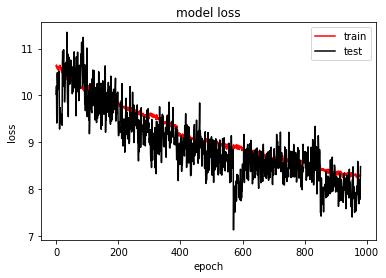

In [33]:
import matplotlib.pyplot as plt

def flatten_list(l):
     return [point for elem in l for point in elem]

plt.plot(loss_history[0], color="red", label="train")
plt.plot(loss_history[1], color="black", label="test")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()


#Show first 200 epochs, then zoom in on last so this is from 220 + 400 = 620 epochs

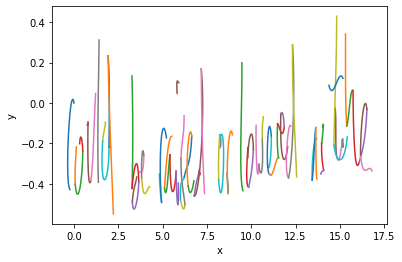

In [77]:
import sys
sys.path.insert(0, "../autowrite")
from Visualizer import Visualizer

visualizer = Visualizer()
visualizer.plot_bezier_curves(padded_features[10])

In [78]:
print(len(loss_history[0]))

571


In [79]:
from pathlib import Path
if Path("./../../data/processed_data/alphabet").is_file():
    with open("./../../data/processed_data/alphabet", "rb") as f:
        alphabet = pickle.load(f)

print(alphabet, len(alphabet))

def encode_textline(textline, alphabet):
    return [alphabet.index(c) for c in textline]

def decode_textline(encodedline, alphabet):
    return [alphabet[int(v)] if int(v) < len(alphabet) else "blank"for v in encodedline]

def remove_blanks(l):
    return [elem for elem in l if elem != "blank"]

['&', 'T', '!', 'h', '9', 'V', '\n', 'b', 'o', 'j', 'f', '"', 'i', 'Z', 'a', 'D', '?', '*', ':', '7', 'k', 's', 'B', 'R', '3', 'U', '8', 'n', 'l', ';', 'M', ',', ')', 'r', '#', 'G', 'm', 'A', 'x', 'O', '4', 'E', 'L', 'g', '6', 'F', '@', 'Q', 'q', 'u', '1', 'W', 'w', 'z', "'", 't', 'X', 'H', 'c', '[', 'p', 'C', '+', '5', 'd', 'P', '.', 'v', 'I', 'S', 'e', 'N', 'y', 'K', '/', '(', 'J', '0', '2', ' ', '-', 'Y'] 82


In [17]:
# model = build_model(N_BLSTM_LAYERS, N_CELLS, N_FEATURES, OUTPUT_SIZE)
# checkpoint_path = "../../training/checkpoints/encoder_bezier/cp.ckpt"
# model.load_weights(checkpoint_path)

In [18]:
from Preprocessor import Preprocessor
preprocessor = Preprocessor("../../data/processed_data/alphabet")

path = "./input_example.npy"
raw_strokes = np.load(path, allow_pickle=True)
p = preprocessor.strokes_to_bezier(raw_strokes, precision=0.01)

In [25]:
i = 500
# sample = padded_features[i]
sample = p
output = model.call(tf.convert_to_tensor(np.expand_dims(sample, 0)), mask=None)
print(output.shape)
res = output.numpy()[0]

(1, 21, 83)


In [23]:
argmax = np.argmax(res, axis=1)

nazi documents , were captured
dehut


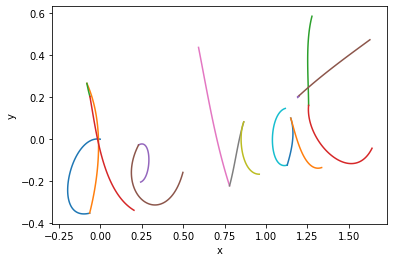

In [24]:
import matplotlib.pyplot as plt

print("".join(remove_blanks(decode_textline(padded_target[i], alphabet))))

print("".join(remove_blanks(decode_textline(argmax, alphabet))))

visualizer.plot_bezier_curves(sample)

In [172]:
np.save("test", sample)

In [173]:
reshaped_output = tf.reshape(output, (output.shape[1], output.shape[0], output.shape[2]))
(decoded, log_probabilities) = tf.nn.ctc_beam_search_decoder(reshaped_output, [reshaped_output.shape[0]], beam_width=3)

In [174]:
print(decode_textline(decoded[0].values, alphabet))

['a', ' ', 'c', 'u', 'q', 'u', 'a', 't', 'e', ' ', 't', 'o', ' ', 'w', 'i', 't', 'h', 'h', 's', 't', 'a', 'n', 'd', ' ', 't', 'h', 'e', ' ', '.', ' ', '.', ' ', '.', ' ', '.', ' ', '.', ' ', '.', ' ', '.', ' ', '&', ' ', '&', ' ', '&', ' ']


In [175]:
import kenlm
from pyctcdecode import build_ctcdecoder

# load unigram list
with open("librispeech-vocab.txt") as f:
    unigram_list = [t for t in f.read().strip().split("\n")]

decoder = build_ctcdecoder(
    alphabet,
#     kenlm_model_path="./3-gram.pruned.1e-7.arpa",
#     unigrams=unigram_list,
#     alpha=1.0,  # tuned on a val set 
#     beta=0.1,  # tuned on a val set 
)
text = decoder.decode(res)
print(text)

acuquate to with stand the


In [176]:
# download pretrained knelm model for librispeech
import gzip
import os, shutil, wget

lm_gzip_path = '3-gram.pruned.1e-7.arpa.gz'
if not os.path.exists(lm_gzip_path):
    print('Downloading pruned 3-gram model.')
    lm_url = 'http://www.openslr.org/resources/11/3-gram.pruned.1e-7.arpa.gz'
    lm_gzip_path = wget.download(lm_url)
    print('Downloaded the 3-gram language model.')
else:
    print('Pruned .arpa.gz already exists.')

# NOTE: since out nemo vocabulary is all lowercased, we need to convert all librispeech data as well
uppercase_lm_path = '3-gram.pruned.1e-7.arpa'
if not os.path.exists(uppercase_lm_path):
    with gzip.open(lm_gzip_path, 'rb') as f_zipped:
        with open(uppercase_lm_path, 'wb') as f_unzipped:
            shutil.copyfileobj(f_zipped, f_unzipped)
    print('Unzipped the 3-gram language model.')
else:
    print('Unzipped .arpa already exists.')

Pruned .arpa.gz already exists.
Unzipped .arpa already exists.


In [343]:
!wget http://www.openslr.org/resources/11/librispeech-vocab.txt

--2022-06-19 08:54:18--  http://www.openslr.org/resources/11/librispeech-vocab.txt
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://us.openslr.org/resources/11/librispeech-vocab.txt [following]
--2022-06-19 08:54:18--  https://us.openslr.org/resources/11/librispeech-vocab.txt
Resolving us.openslr.org (us.openslr.org)... 46.101.158.64
Connecting to us.openslr.org (us.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1737588 (1.7M) [text/plain]
Saving to: ‘librispeech-vocab.txt.1’

librispeech-vocab.t 100%[===================>]   1.66M  --.-KB/s    in 0.1s    

2022-06-19 08:54:18 (16.5 MB/s) - ‘librispeech-vocab.txt.1’ saved [1737588/1737588]

